In [25]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [19]:
class DataProcessor:
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.le = LabelEncoder()
        
    def process_features(self, df):
        # Numerical features
        num_cols = ['Annual_Income', 'Num_Bank_Accounts',
                   'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 
                   'Delay_from_due_date', 'Num_of_Delayed_Payment',
                   'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
                   'Total_EMI_per_month', 'Amount_invested_monthly',
                   'Monthly_Balance']
                   
        # Categorical features
        cat_cols = ['Occupation', 'Credit_Mix', 'Payment_Behaviour', 'Payment_of_Min_Amount']
        
        # Scale numerical features
        df[num_cols] = self.scaler.fit_transform(df[num_cols])
        
        # Encode categorical features
        for col in cat_cols:
            df[col] = self.le.fit_transform(df[col])
            
        return df

# Load and process data
df = pd.read_csv("Creditscore_train_cleaned.csv")
processor = DataProcessor()
df = processor.process_features(df)

X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

joblib.dump(processor, 'credit_score_processor.joblib')

['credit_score_processor.joblib']

In [21]:
def get_base_models():
    models = {}
    
    # LightGBM
    lgb_params = {
        'objective': 'multiclass',
        'num_class': 3,
        'learning_rate': 0.01,
        'n_estimators': 1000,
        'max_depth': 7,
        'num_leaves': 31,
        'min_child_samples': 20,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # XGBoost
    xgb_params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'learning_rate': 0.01,
        'n_estimators': 1000,
        'max_depth': 7,
        'min_child_weight': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'random_state': 42,
        'n_jobs': -1
    }
    
    models['lgb'] = lgb.LGBMClassifier(**lgb_params)
    models['xgb'] = xgb.XGBClassifier(**xgb_params)
    
    return models

In [22]:

class EnsembleModel:
    def __init__(self, models, n_splits=5):
        self.models = models
        self.n_splits = n_splits
        self.trained_models = {name: [] for name in models.keys()}
        self.weights = None
        
    def train(self, X, y):
        X_resampled, y_resampled = X, y
        
        # Cross validation predictions
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        val_predictions = np.zeros((len(X_resampled), len(self.models), 3))
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_resampled, y_resampled)):
            X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
            y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]
            
            for i, (name, model) in enumerate(self.models.items()):
                # Train model
                model.fit(X_train, y_train)
                self.trained_models[name].append(model)
                
                # Get validation predictions
                val_pred = model.predict_proba(X_val)
                val_predictions[val_idx, i] = val_pred
                
        # Optimize weights using validation predictions
        self.optimize_weights(val_predictions, y_resampled)
        
        # Final training on full dataset
        for name, model in self.models.items():
            model.fit(X_resampled, y_resampled)
            
    def optimize_weights(self, predictions, y_true):
        from scipy.optimize import minimize
        
        def loss_function(weights):
            weighted_preds = np.sum(predictions * weights.reshape(1, -1, 1), axis=1)
            return -accuracy_score(y_true, weighted_preds.argmax(axis=1))
        
        initial_weights = np.ones(len(self.models)) / len(self.models)
        bounds = [(0, 1)] * len(self.models)
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        
        result = minimize(loss_function, initial_weights, bounds=bounds, constraints=constraints)
        self.weights = result.x
        
    def predict_proba(self, X):
        predictions = np.zeros((len(X), len(self.models), 3))
        
        for i, (name, model) in enumerate(self.models.items()):
            pred = model.predict_proba(X)
            predictions[:, i] = pred
            
        return np.sum(predictions * self.weights.reshape(1, -1, 1), axis=1)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [23]:
# Initialize models
base_models = get_base_models()
ensemble = EnsembleModel(base_models)

# Train
print("Training ensemble model...")
ensemble.train(X, y)

# Evaluate
y_pred = ensemble.predict(X)
print("\nTraining Results:")
print(classification_report(y, y_pred))

# Save models and weights
model_artifacts = {
    'processor': processor,
    'models': ensemble.models,
    'weights': ensemble.weights
}
joblib.dump(model_artifacts, 'credit_score_ensemble.joblib')
print("\nModel artifacts saved successfully!")

Training ensemble model...

Training Results:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     27013
           1       0.81      0.78      0.80     49293
           2       0.66      0.72      0.69     15979

    accuracy                           0.76     92285
   macro avg       0.74      0.75      0.75     92285
weighted avg       0.77      0.76      0.77     92285


Model artifacts saved successfully!


In [12]:
def predict_credit_score(data):
    # Load artifacts
    artifacts = joblib.load('credit_score_ensemble.joblib')
    processor = artifacts['processor']
    
    # Process features
    X = processor.process_features(data.copy())
    
    # Initialize ensemble
    ensemble = EnsembleModel(artifacts['models'])
    ensemble.weights = artifacts['weights']
    
    # Generate predictions
    predictions = ensemble.predict(X)
    probabilities = ensemble.predict_proba(X)
    
    return predictions, probabilities

# Test prediction
test_data = pd.read_csv("Creditscore_test_cleaned.csv")
preds, probs = predict_credit_score(test_data)

results_df = pd.DataFrame({
    'Predicted_Score': preds,
    'Good_Prob': probs[:,0],
    'Standard_Prob': probs[:,1],
    'Poor_Prob': probs[:,2]
})

c:\Users\rahul\miniconda3\envs\llm\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rahul\miniconda3\envs\llm\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


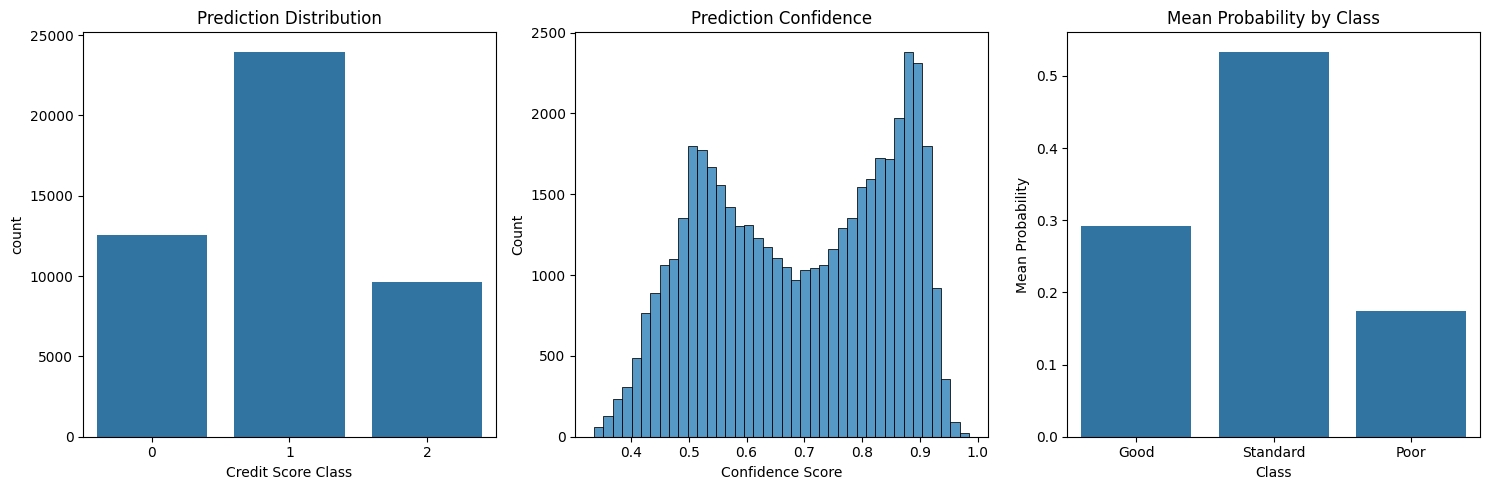


Prediction Summary:
--------------------------------------------------
Total Predictions: 46120

Class Distribution:
0    12538
1    23973
2     9609
Name: count, dtype: int64

Mean Confidence Score: 0.6900
Median Confidence Score: 0.6978

Predictions saved to 'credit_score_predictions.csv'


In [26]:
def analyze_predictions(predictions, probabilities):
    # Create results visualization
    plt.figure(figsize=(15,5))
    
    # Plot 1: Prediction Distribution
    plt.subplot(131)
    sns.countplot(x=predictions)
    plt.title('Prediction Distribution')
    plt.xlabel('Credit Score Class')
    
    # Plot 2: Confidence Scores
    plt.subplot(132)
    confidence_scores = np.max(probabilities, axis=1)
    sns.histplot(confidence_scores)
    plt.title('Prediction Confidence')
    plt.xlabel('Confidence Score')
    
    # Plot 3: Mean Probability per Class
    plt.subplot(133)
    mean_probs = pd.DataFrame({
        'Class': ['Good', 'Standard', 'Poor'],
        'Mean Probability': [
            probabilities[:,0].mean(),
            probabilities[:,1].mean(), 
            probabilities[:,2].mean()
        ]
    })
    sns.barplot(data=mean_probs, x='Class', y='Mean Probability')
    plt.title('Mean Probability by Class')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPrediction Summary:")
    print("-"*50)
    print(f"Total Predictions: {len(predictions)}")
    print("\nClass Distribution:")
    print(pd.Series(predictions).value_counts().sort_index())
    print("\nMean Confidence Score: {:.4f}".format(confidence_scores.mean()))
    print("Median Confidence Score: {:.4f}".format(np.median(confidence_scores)))

# Analyze results
analyze_predictions(preds, probs)

# Export results
results_df.to_csv('credit_score_predictions.csv', index=False)
print("\nPredictions saved to 'credit_score_predictions.csv'")

In [15]:
import xgboost as xgb
xgb_params = {
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'objective': 'multi:softprob',
    'num_class': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1
}

model = xgb.XGBClassifier(**xgb_params)
model.fit(
    X_train_processed,
    y_train,
    eval_set=[(X_test_processed, y_test)],
    verbose=1
)


[0]	validation_0-mlogloss:1.09334
[1]	validation_0-mlogloss:1.08845
[2]	validation_0-mlogloss:1.08348
[3]	validation_0-mlogloss:1.07848
[4]	validation_0-mlogloss:1.07354
[5]	validation_0-mlogloss:1.06915
[6]	validation_0-mlogloss:1.06437
[7]	validation_0-mlogloss:1.05961
[8]	validation_0-mlogloss:1.05494
[9]	validation_0-mlogloss:1.05039
[10]	validation_0-mlogloss:1.04587
[11]	validation_0-mlogloss:1.04185
[12]	validation_0-mlogloss:1.03785
[13]	validation_0-mlogloss:1.03356
[14]	validation_0-mlogloss:1.02975
[15]	validation_0-mlogloss:1.02565
[16]	validation_0-mlogloss:1.02153
[17]	validation_0-mlogloss:1.01777
[18]	validation_0-mlogloss:1.01394
[19]	validation_0-mlogloss:1.01000
[20]	validation_0-mlogloss:1.00612
[21]	validation_0-mlogloss:1.00297
[22]	validation_0-mlogloss:1.00004
[23]	validation_0-mlogloss:0.99634
[24]	validation_0-mlogloss:0.99287
[25]	validation_0-mlogloss:0.98940
[26]	validation_0-mlogloss:0.98590
[27]	validation_0-mlogloss:0.98254
[28]	validation_0-mlogloss:0.9

c:\Users\rahul\miniconda3\envs\llm\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1, num_class=3,
              num_parallel_tree=None, ...)

In [16]:
def evaluate_model(model, X, y, label=""):
    preds = model.predict(X)
    print(f"\n{label} Results:")
    print(classification_report(y, preds))

evaluate_model(model, X_train_processed, y_train, "Training")
evaluate_model(model, X_test_processed, y_test, "Test")

# Cell 7: Save Model
import joblib
joblib.dump(preprocessor, 'credit_score_preprocessor.joblib')
joblib.dump(model, 'credit_score_xgb_model.joblib')

# Cell 8: Prediction Function
def predict_credit_score(data):
    preprocessor = joblib.load('credit_score_preprocessor.joblib')
    model = joblib.load('credit_score_xgb_model.joblib')
    
    X_processed = preprocessor.transform(data)
    predictions = model.predict(X_processed)
    probabilities = model.predict_proba(X_processed)
    
    return predictions, probabilities


Training Results:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71     21610
           1       0.79      0.75      0.77     39435
           2       0.55      0.73      0.63     12783

    accuracy                           0.72     73828
   macro avg       0.70      0.72      0.70     73828
weighted avg       0.74      0.72      0.73     73828


Test Results:
              precision    recall  f1-score   support

           0       0.72      0.64      0.67      5403
           1       0.77      0.72      0.74      9858
           2       0.52      0.71      0.60      3196

    accuracy                           0.70     18457
   macro avg       0.67      0.69      0.67     18457
weighted avg       0.71      0.70      0.70     18457

